In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import PIL
import PIL.Image
import tensorflow_datasets as tfds
import pathlib 
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

2023-11-10 00:21:14.156274: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 00:21:14.182371: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h4>Images Paths</h4>

In [2]:
train_path = "assets/train"
valid_path = "assets/valid"
test_path = "assets/test"

<h4>Check Images Path</h4>

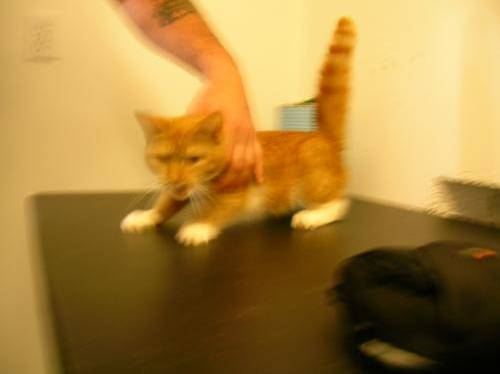

In [3]:

cats = list(pathlib.Path(train_path).glob('*/*.jpg'))
firstImage = PIL.Image.open(str(cats[0])).show()


<h4>Model Training Arguments</h4>

In [4]:
batch_size = 75
img_height = 224
img_width =  224
seed = 123

<h4>Datasets</h4>

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    # validation_split=0.2,
    # subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.


2023-11-10 00:21:27.513038: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-10 00:21:27.517008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-10 00:21:27.517141: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-10 00:21:27.518276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-10 00:21:27.518388: I tensorflow/compile

In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_path,
    #validation_split=0.2,
    #subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
),

Found 2000 files belonging to 2 classes.


In [7]:

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    # validation_split=0.2,
    # subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical',
    shuffle=False
)

Found 500 files belonging to 2 classes.


<h4>Check Class Names</h4>

In [8]:
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


<h4>Check Images in Dataset</h4>

tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(0, shape=(), dtype=int32)


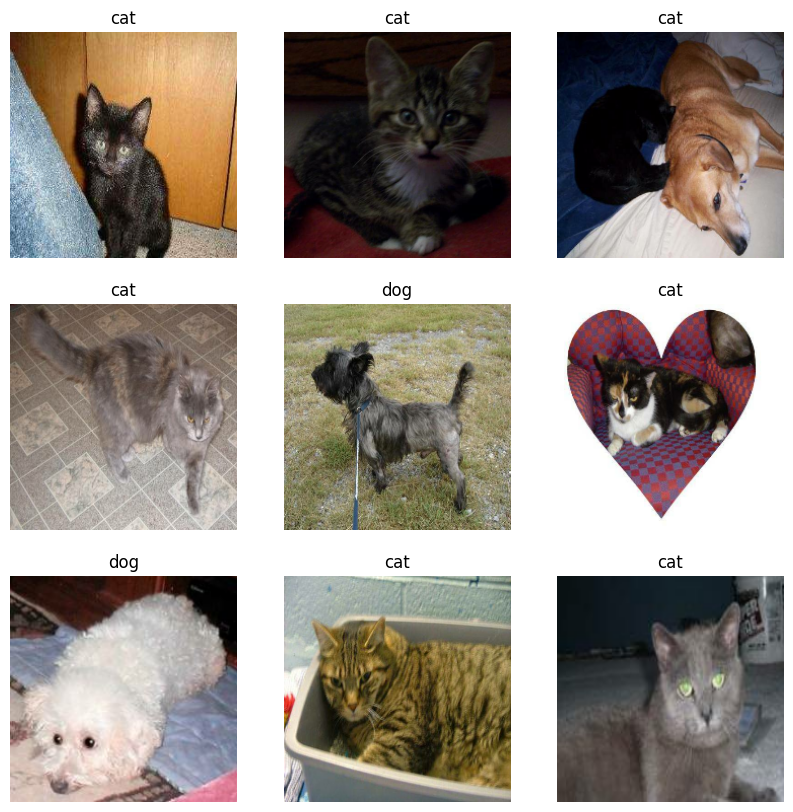

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    print(labels[i])
    plt.axis("off")

<h4>Check Shapes</h4>

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(75, 224, 224, 3)
(75,)


<h4>Normalization </h4>

In [11]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


<h4>Configure The Dataset For Performance</h4>

In [12]:
#AUTOTUNE = tf.data.AUTOTUNE

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

<h4>Train a Model</h4>

In [13]:
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [15]:
# train_history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=40,
#   verbose=2
# )

<h4>Build Fine Tune VGG 16 Model</h4>

In [16]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [17]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
type(vgg16_model)

keras.src.engine.functional.Functional

In [19]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [20]:
for layer in model.layers:
    layer.trainable = False

In [21]:
model.add(Dense(units=2, activation='softmax'))

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [23]:
model.compile(
  optimizer=Adam(learning_rate=0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  #loss='categorical_crossentropy',
  metrics=['accuracy']
)

In [24]:
train_history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=5,
  verbose=2
)

Epoch 1/40


/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2023-11-10 00:21:37.212389: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-10 00:21:38.408826: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 934.89MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-11-10 00:21:38.442697: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more

134/134 - 31s - loss: 0.3114 - accuracy: 0.8753 - val_loss: 0.1272 - val_accuracy: 0.9495 - 31s/epoch - 230ms/step
Epoch 2/40
134/134 - 26s - loss: 0.1123 - accuracy: 0.9549 - val_loss: 0.1003 - val_accuracy: 0.9595 - 26s/epoch - 191ms/step
Epoch 3/40
134/134 - 26s - loss: 0.0913 - accuracy: 0.9644 - val_loss: 0.0916 - val_accuracy: 0.9640 - 26s/epoch - 195ms/step
Epoch 4/40
134/134 - 26s - loss: 0.0801 - accuracy: 0.9714 - val_loss: 0.0852 - val_accuracy: 0.9675 - 26s/epoch - 194ms/step
Epoch 5/40
134/134 - 26s - loss: 0.0727 - accuracy: 0.9736 - val_loss: 0.0835 - val_accuracy: 0.9670 - 26s/epoch - 195ms/step
Epoch 6/40
134/134 - 26s - loss: 0.0673 - accuracy: 0.9761 - val_loss: 0.0805 - val_accuracy: 0.9690 - 26s/epoch - 196ms/step
Epoch 7/40
134/134 - 26s - loss: 0.0628 - accuracy: 0.9767 - val_loss: 0.0741 - val_accuracy: 0.9720 - 26s/epoch - 195ms/step
Epoch 8/40
134/134 - 26s - loss: 0.0581 - accuracy: 0.9792 - val_loss: 0.0742 - val_accuracy: 0.9740 - 26s/epoch - 192ms/step
Epo

<h4>Predictions</h4>

In [25]:
predictions = model.predict(x=test_ds, verbose=0)

In [26]:
rounded_predictions = np.argmax(predictions, axis=-1)
print(rounded_predictions)

[0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

<h4>Visualize Output</h4>

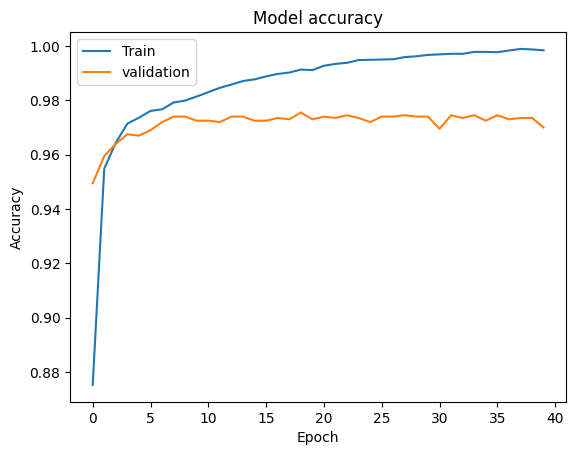

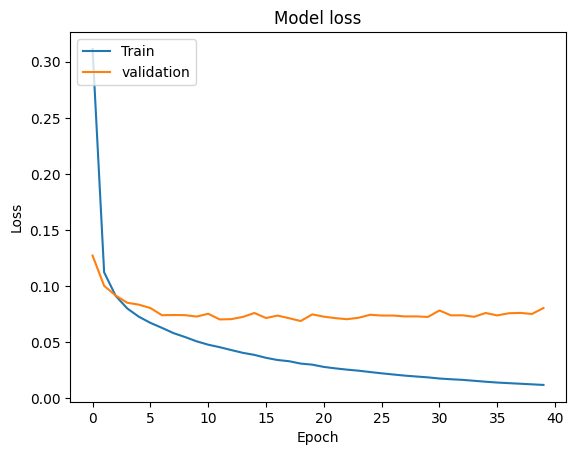

In [27]:
plt.plot(train_history.history['accuracy'])
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

# 绘制训练 & 验证的损失值
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [28]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[245   5]
 [  7 243]]


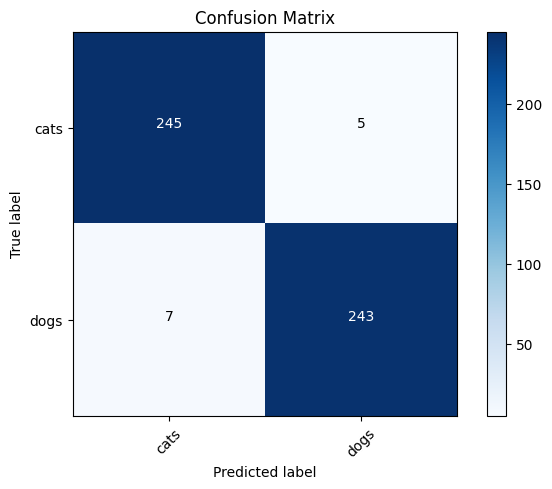

In [29]:
predictions_cm = np.array([])
test_labels =  np.array([])
for x, y in test_ds:

  predictions_cm = np.argmax(predictions,axis=1)
  test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

cm = tf.math.confusion_matrix(labels=test_labels, predictions=predictions_cm).numpy()
cm_plot_labels= ['cats','dogs']


plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

<h4>Save The Model</h4>

In [30]:
import os.path
filepath = 'model/image_classification_model.keras' 
if os.path.isfile(filepath) is False:
    model.save(filepath)

<h4>Load a Model</h4>

In [31]:
# from keras.models import load_model
# loaded_model = load_model(filepath)
# loaded_model.summary()